In [1]:
from data import COCODetection, get_label_map, MEANS, COLORS
from yolact import Yolact
from utils.augmentations import BaseTransform, FastBaseTransform, Resize
from utils.functions import MovingAverage, ProgressBar
from layers.box_utils import jaccard, center_size, mask_iou
from utils import timer
from utils.functions import SavePath
from layers.output_utils import postprocess, undo_image_transformation
import pycocotools

from data import cfg, set_cfg, set_dataset

import numpy as np
import torch
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import argparse
import time
import random
import cProfile
import pickle
import json
import os
from collections import defaultdict
from pathlib import Path
from collections import OrderedDict
from PIL import Image

import matplotlib.pyplot as plt
import cv2

from attrdict import AttrDict

In [2]:
!pip install attrdict

In [3]:
def str2bool(v):
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

def parse_args(argv=None):
    global args
    args = {'trained_model': 'weights/yolact_im700_54_800000.pth', 'top_k': 15, 'cuda': True, 'fast_nms': True, 'cross_class_nms': False, 'display_masks': True, 'display_bboxes': True, 'display_text': True, 'display_scores': True, 'display': False, 'shuffle': False, 'ap_data_file': 'results/ap_data.pkl', 'resume': False, 'max_images': -1, 'output_coco_json': False, 'bbox_det_file':'results/bbox_detections.json', 'mask_det_file': 'results/mask_detections.json', 'config': 'yolact_im700_config', 'output_web_json': False, 'web_det_path': 'web/dets/', 'no_bar': False, 'display_lincomb': False, 'benchmark': False, 'no_sort': False, 'seed': None, 'mask_proto_debug': False, 'crop': True, 'image': 'images/car.jpg', 'images': None, 'video': None, 'video_multiframe': 1, 'score_threshold': 0.8, 'dataset': None, 'detect': False, 'display_fps': False, 'emulate_playback': False, 'no_hash': False}
    args['cuda'] = False
    args['top_k'] = 15
    args['image'] = 'images/car.jpg'
    args = AttrDict(args)

iou_thresholds = [x / 100 for x in range(50, 100, 5)]
coco_cats = {} # Call prep_coco_cats to fill this
coco_cats_inv = {}
color_cache = defaultdict(lambda: {})

def prep_display(dets_out, img, h, w, undo_transform=True, class_color=False, mask_alpha=0.45, fps_str=''):
    """
    Note: If undo_transform=False then im_h and im_w are allowed to be None.
    """
    if undo_transform:
        img_numpy = undo_image_transformation(img, w, h)
        img_gpu = torch.Tensor(img_numpy).cuda()
    else:
        img_gpu = img / 255.0
        h, w, _ = img.shape
    
    with timer.env('Postprocess'):
        save = cfg.rescore_bbox
        cfg.rescore_bbox = True
        t = postprocess(dets_out, w, h, visualize_lincomb = args.display_lincomb,
                                        crop_masks        = args.crop,
                                        score_threshold   = args.score_threshold)
        cfg.rescore_bbox = save

    with timer.env('Copy'):
        idx = t[1].argsort(0, descending=True)[:args.top_k]
        
        if cfg.eval_mask_branch:
            # Masks are drawn on the GPU, so don't copy
            masks = t[3][idx]
        classes, scores, boxes = [x[idx].cpu().numpy() for x in t[:3]]

    num_dets_to_consider = min(args.top_k, classes.shape[0])
    for j in range(num_dets_to_consider):
        if scores[j] < args.score_threshold:
            num_dets_to_consider = j
            break

    # Quick and dirty lambda for selecting the color for a particular index
    # Also keeps track of a per-gpu color cache for maximum speed
    def get_color(j, on_gpu=None):
        global color_cache
        color_idx = (classes[j] * 5 if class_color else j * 5) % len(COLORS)
        
        if on_gpu is not None and color_idx in color_cache[on_gpu]:
            return color_cache[on_gpu][color_idx]
        else:
            color = COLORS[color_idx]
            if not undo_transform:
                # The image might come in as RGB or BRG, depending
                # color = np.array([color[2], color[1], color[0]])
                color = torch.Tensor((color[2], color[1], color[0]))
            if on_gpu is not None:
                color = torch.Tensor(color).to(on_gpu).float() / 255.
                color_cache[on_gpu][color_idx] = color
            return color

    # First, draw the masks on the GPU where we can do it really fast
    # Beware: very fast but possibly unintelligible mask-drawing code ahead
    # I wish I had access to OpenGL or Vulkan but alas, I guess Pytorch tensor operations will have to suffice
    if args.display_masks and cfg.eval_mask_branch and num_dets_to_consider > 0:
        # After this, mask is of size [num_dets, h, w, 1]
        masks = masks[:num_dets_to_consider, :, :, None]
        
        # Prepare the RGB images for each mask given their color (size [num_dets, h, w, 1])
        # colors = torch.cat([get_color(j, on_gpu=img_gpu.device.index).view(1, 1, 1, 3) for j in range(num_dets_to_consider)], dim=0)
        colors = torch.cat(
            [get_color(j).view(1, 1, 1, 3) for j in range(num_dets_to_consider)], dim=0)
        masks_color = masks.repeat(1, 1, 1, 3) * colors * mask_alpha

        # This is 1 everywhere except for 1-mask_alpha where the mask is
        inv_alph_masks = masks * (-mask_alpha) + 1
        
        # I did the math for this on pen and paper. This whole block should be equivalent to:
        #    for j in range(num_dets_to_consider):
        #        img_gpu = img_gpu * inv_alph_masks[j] + masks_color[j]
        masks_color_summand = masks_color[0]
        if num_dets_to_consider > 1:
            inv_alph_cumul = inv_alph_masks[:(num_dets_to_consider-1)].cumprod(dim=0)
            masks_color_cumul = masks_color[1:] * inv_alph_cumul
            masks_color_summand += masks_color_cumul.sum(dim=0)

        img_gpu = img_gpu * inv_alph_masks.prod(dim=0) + masks_color_summand
    
    if args.display_fps:
            # Draw the box for the fps on the GPU
        font_face = cv2.FONT_HERSHEY_DUPLEX
        font_scale = 0.6
        font_thickness = 1

        text_w, text_h = cv2.getTextSize(fps_str, font_face, font_scale, font_thickness)[0]

        img_gpu[0:text_h+8, 0:text_w+8] *= 0.6 # 1 - Box alpha


    # Then draw the stuff that needs to be done on the cpu
    # Note, make sure this is a uint8 tensor or opencv will not anti alias text for whatever reason
    img_numpy = (img_gpu * 255).byte().cpu().numpy()

    if args.display_fps:
        # Draw the text on the CPU
        text_pt = (4, text_h + 2)
        text_color = [255, 255, 255]

        cv2.putText(img_numpy, fps_str, text_pt, font_face, font_scale, text_color, font_thickness, cv2.LINE_AA)
    
    if num_dets_to_consider == 0:
        return img_numpy

    if args.display_text or args.display_bboxes:
        for j in reversed(range(num_dets_to_consider)):
            x1, y1, x2, y2 = boxes[j, :]
            color = get_color(j).numpy()
            color = (int(color[0]), int(color[1]), int(color[2]))
            score = scores[j]

            if args.display_bboxes:
                cv2.rectangle(img_numpy, (x1, y1), (x2, y2), color, 1)

            if args.display_text:
                _class = cfg.dataset.class_names[classes[j]]
                text_str = '%s: %.2f' % (_class, score) if args.display_scores else _class

                font_face = cv2.FONT_HERSHEY_DUPLEX
                font_scale = 0.6
                font_thickness = 1

                text_w, text_h = cv2.getTextSize(text_str, font_face, font_scale, font_thickness)[0]

                text_pt = (x1, y1 - 3)
                text_color = [255, 255, 255]

                cv2.rectangle(img_numpy, (x1, y1), (x1 + text_w, y1 - text_h - 4), color, -1)
                cv2.putText(img_numpy, text_str, text_pt, font_face, font_scale, text_color, font_thickness, cv2.LINE_AA)
            
    
    return img_numpy

def prep_benchmark(dets_out, h, w):
    with timer.env('Postprocess'):
        t = postprocess(dets_out, w, h, crop_masks=args.crop, score_threshold=args.score_threshold)

    with timer.env('Copy'):
        classes, scores, boxes, masks = [x[:args.top_k] for x in t]
        if isinstance(scores, list):
            box_scores = scores[0].cpu().numpy()
            mask_scores = scores[1].cpu().numpy()
        else:
            scores = scores.cpu().numpy()
        classes = classes.cpu().numpy()
        boxes = boxes.cpu().numpy()
        masks = masks.cpu().numpy()
    
    with timer.env('Sync'):
        # Just in case
        torch.cuda.synchronize()

def prep_coco_cats():
    """ Prepare inverted table for category id lookup given a coco cats object. """
    for coco_cat_id, transformed_cat_id_p1 in get_label_map().items():
        transformed_cat_id = transformed_cat_id_p1 - 1
        coco_cats[transformed_cat_id] = coco_cat_id
        coco_cats_inv[coco_cat_id] = transformed_cat_id


def get_coco_cat(transformed_cat_id):
    """ transformed_cat_id is [0,80) as indices in cfg.dataset.class_names """
    return coco_cats[transformed_cat_id]

def get_transformed_cat(coco_cat_id):
    """ transformed_cat_id is [0,80) as indices in cfg.dataset.class_names """
    return coco_cats_inv[coco_cat_id]


class Detections:

    def __init__(self):
        self.bbox_data = []
        self.mask_data = []

    def add_bbox(self, image_id:int, category_id:int, bbox:list, score:float):
        """ Note that bbox should be a list or tuple of (x1, y1, x2, y2) """
        bbox = [bbox[0], bbox[1], bbox[2]-bbox[0], bbox[3]-bbox[1]]

        # Round to the nearest 10th to avoid huge file sizes, as COCO suggests
        bbox = [round(float(x)*10)/10 for x in bbox]

        self.bbox_data.append({
            'image_id': int(image_id),
            'category_id': get_coco_cat(int(category_id)),
            'bbox': bbox,
            'score': float(score)
        })

    def add_mask(self, image_id:int, category_id:int, segmentation:np.ndarray, score:float):
        """ The segmentation should be the full mask, the size of the image and with size [h, w]. """
        rle = pycocotools.mask.encode(np.asfortranarray(segmentation.astype(np.uint8)))
        rle['counts'] = rle['counts'].decode('ascii') # json.dump doesn't like bytes strings

        self.mask_data.append({
            'image_id': int(image_id),
            'category_id': get_coco_cat(int(category_id)),
            'segmentation': rle,
            'score': float(score)
        })
    
    def dump(self):
        dump_arguments = [
            (self.bbox_data, args.bbox_det_file),
            (self.mask_data, args.mask_det_file)
        ]

        for data, path in dump_arguments:
            with open(path, 'w') as f:
                json.dump(data, f)
    
    def dump_web(self):
        """ Dumps it in the format for my web app. Warning: bad code ahead! """
        config_outs = ['preserve_aspect_ratio', 'use_prediction_module',
                        'use_yolo_regressors', 'use_prediction_matching',
                        'train_masks']

        output = {
            'info' : {
                'Config': {key: getattr(cfg, key) for key in config_outs},
            }
        }

        image_ids = list(set([x['image_id'] for x in self.bbox_data]))
        image_ids.sort()
        image_lookup = {_id: idx for idx, _id in enumerate(image_ids)}

        output['images'] = [{'image_id': image_id, 'dets': []} for image_id in image_ids]

        # These should already be sorted by score with the way prep_metrics works.
        for bbox, mask in zip(self.bbox_data, self.mask_data):
            image_obj = output['images'][image_lookup[bbox['image_id']]]
            image_obj['dets'].append({
                'score': bbox['score'],
                'bbox': bbox['bbox'],
                'category': cfg.dataset.class_names[get_transformed_cat(bbox['category_id'])],
                'mask': mask['segmentation'],
            })

        with open(os.path.join(args.web_det_path, '%s.json' % cfg.name), 'w') as f:
            json.dump(output, f)
        

        

def _mask_iou(mask1, mask2, iscrowd=False):
    with timer.env('Mask IoU'):
        ret = mask_iou(mask1, mask2, iscrowd)
    return ret.cpu()

def _bbox_iou(bbox1, bbox2, iscrowd=False):
    with timer.env('BBox IoU'):
        ret = jaccard(bbox1, bbox2, iscrowd)
    return ret.cpu()

def prep_metrics(ap_data, dets, img, gt, gt_masks, h, w, num_crowd, image_id, detections:Detections=None):
    """ Returns a list of APs for this image, with each element being for a class  """
    if not args.output_coco_json:
        with timer.env('Prepare gt'):
            gt_boxes = torch.Tensor(gt[:, :4])
            gt_boxes[:, [0, 2]] *= w
            gt_boxes[:, [1, 3]] *= h
            gt_classes = list(gt[:, 4].astype(int))
            gt_masks = torch.Tensor(gt_masks).view(-1, h*w)

            if num_crowd > 0:
                split = lambda x: (x[-num_crowd:], x[:-num_crowd])
                crowd_boxes  , gt_boxes   = split(gt_boxes)
                crowd_masks  , gt_masks   = split(gt_masks)
                crowd_classes, gt_classes = split(gt_classes)

    with timer.env('Postprocess'):
        classes, scores, boxes, masks = postprocess(dets, w, h, crop_masks=args.crop, score_threshold=args.score_threshold)

        if classes.size(0) == 0:
            return

        classes = list(classes.cpu().numpy().astype(int))
        if isinstance(scores, list):
            box_scores = list(scores[0].cpu().numpy().astype(float))
            mask_scores = list(scores[1].cpu().numpy().astype(float))
        else:
            scores = list(scores.cpu().numpy().astype(float))
            box_scores = scores
            mask_scores = scores
        masks = masks.view(-1, h*w).cuda()
        boxes = boxes.cuda()


    if args.output_coco_json:
        with timer.env('JSON Output'):
            boxes = boxes.cpu().numpy()
            masks = masks.view(-1, h, w).cpu().numpy()
            for i in range(masks.shape[0]):
                # Make sure that the bounding box actually makes sense and a mask was produced
                if (boxes[i, 3] - boxes[i, 1]) * (boxes[i, 2] - boxes[i, 0]) > 0:
                    detections.add_bbox(image_id, classes[i], boxes[i,:],   box_scores[i])
                    detections.add_mask(image_id, classes[i], masks[i,:,:], mask_scores[i])
            return
    
    with timer.env('Eval Setup'):
        num_pred = len(classes)
        num_gt   = len(gt_classes)

        mask_iou_cache = _mask_iou(masks, gt_masks)
        bbox_iou_cache = _bbox_iou(boxes.float(), gt_boxes.float())

        if num_crowd > 0:
            crowd_mask_iou_cache = _mask_iou(masks, crowd_masks, iscrowd=True)
            crowd_bbox_iou_cache = _bbox_iou(boxes.float(), crowd_boxes.float(), iscrowd=True)
        else:
            crowd_mask_iou_cache = None
            crowd_bbox_iou_cache = None

        box_indices = sorted(range(num_pred), key=lambda i: -box_scores[i])
        mask_indices = sorted(box_indices, key=lambda i: -mask_scores[i])

        iou_types = [
            ('box',  lambda i,j: bbox_iou_cache[i, j].item(),
                     lambda i,j: crowd_bbox_iou_cache[i,j].item(),
                     lambda i: box_scores[i], box_indices),
            ('mask', lambda i,j: mask_iou_cache[i, j].item(),
                     lambda i,j: crowd_mask_iou_cache[i,j].item(),
                     lambda i: mask_scores[i], mask_indices)
        ]

    timer.start('Main loop')
    for _class in set(classes + gt_classes):
        ap_per_iou = []
        num_gt_for_class = sum([1 for x in gt_classes if x == _class])
        
        for iouIdx in range(len(iou_thresholds)):
            iou_threshold = iou_thresholds[iouIdx]

            for iou_type, iou_func, crowd_func, score_func, indices in iou_types:
                gt_used = [False] * len(gt_classes)
                
                ap_obj = ap_data[iou_type][iouIdx][_class]
                ap_obj.add_gt_positives(num_gt_for_class)

                for i in indices:
                    if classes[i] != _class:
                        continue
                    
                    max_iou_found = iou_threshold
                    max_match_idx = -1
                    for j in range(num_gt):
                        if gt_used[j] or gt_classes[j] != _class:
                            continue
                            
                        iou = iou_func(i, j)

                        if iou > max_iou_found:
                            max_iou_found = iou
                            max_match_idx = j
                    
                    if max_match_idx >= 0:
                        gt_used[max_match_idx] = True
                        ap_obj.push(score_func(i), True)
                    else:
                        # If the detection matches a crowd, we can just ignore it
                        matched_crowd = False

                        if num_crowd > 0:
                            for j in range(len(crowd_classes)):
                                if crowd_classes[j] != _class:
                                    continue
                                
                                iou = crowd_func(i, j)

                                if iou > iou_threshold:
                                    matched_crowd = True
                                    break

                        # All this crowd code so that we can make sure that our eval code gives the
                        # same result as COCOEval. There aren't even that many crowd annotations to
                        # begin with, but accuracy is of the utmost importance.
                        if not matched_crowd:
                            ap_obj.push(score_func(i), False)
    timer.stop('Main loop')


class APDataObject:
    """
    Stores all the information necessary to calculate the AP for one IoU and one class.
    Note: I type annotated this because why not.
    """

    def __init__(self):
        self.data_points = []
        self.num_gt_positives = 0

    def push(self, score:float, is_true:bool):
        self.data_points.append((score, is_true))
    
    def add_gt_positives(self, num_positives:int):
        """ Call this once per image. """
        self.num_gt_positives += num_positives

    def is_empty(self) -> bool:
        return len(self.data_points) == 0 and self.num_gt_positives == 0

    def get_ap(self) -> float:
        """ Warning: result not cached. """

        if self.num_gt_positives == 0:
            return 0

        # Sort descending by score
        self.data_points.sort(key=lambda x: -x[0])

        precisions = []
        recalls    = []
        num_true  = 0
        num_false = 0

        # Compute the precision-recall curve. The x axis is recalls and the y axis precisions.
        for datum in self.data_points:
            # datum[1] is whether the detection a true or false positive
            if datum[1]: num_true += 1
            else: num_false += 1
            
            precision = num_true / (num_true + num_false)
            recall    = num_true / self.num_gt_positives

            precisions.append(precision)
            recalls.append(recall)

        # Smooth the curve by computing [max(precisions[i:]) for i in range(len(precisions))]
        # Basically, remove any temporary dips from the curve.
        # At least that's what I think, idk. COCOEval did it so I do too.
        for i in range(len(precisions)-1, 0, -1):
            if precisions[i] > precisions[i-1]:
                precisions[i-1] = precisions[i]

        # Compute the integral of precision(recall) d_recall from recall=0->1 using fixed-length riemann summation with 101 bars.
        y_range = [0] * 101 # idx 0 is recall == 0.0 and idx 100 is recall == 1.00
        x_range = np.array([x / 100 for x in range(101)])
        recalls = np.array(recalls)

        # I realize this is weird, but all it does is find the nearest precision(x) for a given x in x_range.
        # Basically, if the closest recall we have to 0.01 is 0.009 this sets precision(0.01) = precision(0.009).
        # I approximate the integral this way, because that's how COCOEval does it.
        indices = np.searchsorted(recalls, x_range, side='left')
        for bar_idx, precision_idx in enumerate(indices):
            if precision_idx < len(precisions):
                y_range[bar_idx] = precisions[precision_idx]

        # Finally compute the riemann sum to get our integral.
        # avg([precision(x) for x in 0:0.01:1])
        return sum(y_range) / len(y_range)

def badhash(x):
    """
    Just a quick and dirty hash function for doing a deterministic shuffle based on image_id.

    Source:
    https://stackoverflow.com/questions/664014/what-integer-hash-function-are-good-that-accepts-an-integer-hash-key
    """
    x = (((x >> 16) ^ x) * 0x045d9f3b) & 0xFFFFFFFF
    x = (((x >> 16) ^ x) * 0x045d9f3b) & 0xFFFFFFFF
    x =  ((x >> 16) ^ x) & 0xFFFFFFFF
    return x

def evalimage(net:Yolact, path:str, save_path:str=None):
    # frame = torch.from_numpy(cv2.imread(path)).cuda().float()
    frame = torch.from_numpy(cv2.imread(path)).float()
    batch = FastBaseTransform()(frame.unsqueeze(0))
    preds = net(batch)

    img_numpy = prep_display(preds, frame, None, None, undo_transform=False)
    
    if save_path is None:
        img_numpy = img_numpy[:, :, (2, 1, 0)]

    if save_path is None:
        plt.imshow(img_numpy)
        plt.title(path)
        plt.show()
    else:
        cv2.imwrite(save_path, img_numpy)

def evalimages(net:Yolact, input_folder:str, output_folder:str):
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)

    print()
    for p in Path(input_folder).glob('*'): 
        path = str(p)
        name = os.path.basename(path)
        name = '.'.join(name.split('.')[:-1]) + '.png'
        out_path = os.path.join(output_folder, name)

        evalimage(net, path, out_path)
        print(path + ' -> ' + out_path)
    print('Done.')

from multiprocessing.pool import ThreadPool
from queue import Queue

class CustomDataParallel(torch.nn.DataParallel):
    """ A Custom Data Parallel class that properly gathers lists of dictionaries. """
    def gather(self, outputs, output_device):
        # Note that I don't actually want to convert everything to the output_device
        return sum(outputs, [])

def evalvideo(net:Yolact, path:str, out_path:str=None):
    # If the path is a digit, parse it as a webcam index
    is_webcam = path.isdigit()
    
    # If the input image size is constant, this make things faster (hence why we can use it in a video setting).
    cudnn.benchmark = True
    
    if is_webcam:
        vid = cv2.VideoCapture(int(path))
    else:
        vid = cv2.VideoCapture(path)
    
    if not vid.isOpened():
        print('Could not open video "%s"' % path)
        exit(-1)

    target_fps   = round(vid.get(cv2.CAP_PROP_FPS))
    frame_width  = round(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = round(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    if is_webcam:
        num_frames = float('inf')
    else:
        num_frames = round(vid.get(cv2.CAP_PROP_FRAME_COUNT))

    net = CustomDataParallel(net).cuda()
    transform = torch.nn.DataParallel(FastBaseTransform()).cuda()
    frame_times = MovingAverage(100)
    fps = 0
    frame_time_target = 1 / target_fps
    running = True
    fps_str = ''
    vid_done = False
    frames_displayed = 0

    if out_path is not None:
        out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*"mp4v"), target_fps, (frame_width, frame_height))

    def cleanup_and_exit():
        print()
        pool.terminate()
        vid.release()
        if out_path is not None:
            out.release()
        cv2.destroyAllWindows()
        exit()

    def get_next_frame(vid):
        frames = []
        for idx in range(args.video_multiframe):
            frame = vid.read()[1]
            if frame is None:
                return frames
            frames.append(frame)
        return frames

    def transform_frame(frames):
        with torch.no_grad():
            frames = [torch.from_numpy(frame).cuda().float() for frame in frames]
            return frames, transform(torch.stack(frames, 0))

    def eval_network(inp):
        with torch.no_grad():
            frames, imgs = inp
            num_extra = 0
            while imgs.size(0) < args.video_multiframe:
                imgs = torch.cat([imgs, imgs[0].unsqueeze(0)], dim=0)
                num_extra += 1
            out = net(imgs)
            if num_extra > 0:
                out = out[:-num_extra]
            return frames, out

    def prep_frame(inp, fps_str):
        with torch.no_grad():
            frame, preds = inp
            return prep_display(preds, frame, None, None, undo_transform=False, class_color=True, fps_str=fps_str)

    frame_buffer = Queue()
    video_fps = 0

    # All this timing code to make sure that 
    def play_video():
        try:
            nonlocal frame_buffer, running, video_fps, is_webcam, num_frames, frames_displayed, vid_done

            video_frame_times = MovingAverage(100)
            frame_time_stabilizer = frame_time_target
            last_time = None
            stabilizer_step = 0.0005
            progress_bar = ProgressBar(30, num_frames)

            while running:
                frame_time_start = time.time()

                if not frame_buffer.empty():
                    next_time = time.time()
                    if last_time is not None:
                        video_frame_times.add(next_time - last_time)
                        video_fps = 1 / video_frame_times.get_avg()
                    if out_path is None:
                        cv2.imshow(path, frame_buffer.get())
                    else:
                        out.write(frame_buffer.get())
                    frames_displayed += 1
                    last_time = next_time

                    if out_path is not None:
                        if video_frame_times.get_avg() == 0:
                            fps = 0
                        else:
                            fps = 1 / video_frame_times.get_avg()
                        progress = frames_displayed / num_frames * 100
                        progress_bar.set_val(frames_displayed)

                        print('\rProcessing Frames  %s %6d / %6d (%5.2f%%)    %5.2f fps        '
                            % (repr(progress_bar), frames_displayed, num_frames, progress, fps), end='')

                
                # This is split because you don't want savevideo to require cv2 display functionality (see #197)
                if out_path is None and cv2.waitKey(1) == 27:
                    # Press Escape to close
                    running = False
                if not (frames_displayed < num_frames):
                    running = False

                if not vid_done:
                    buffer_size = frame_buffer.qsize()
                    if buffer_size < args.video_multiframe:
                        frame_time_stabilizer += stabilizer_step
                    elif buffer_size > args.video_multiframe:
                        frame_time_stabilizer -= stabilizer_step
                        if frame_time_stabilizer < 0:
                            frame_time_stabilizer = 0

                    new_target = frame_time_stabilizer if is_webcam else max(frame_time_stabilizer, frame_time_target)
                else:
                    new_target = frame_time_target

                next_frame_target = max(2 * new_target - video_frame_times.get_avg(), 0)
                target_time = frame_time_start + next_frame_target - 0.001 # Let's just subtract a millisecond to be safe
                
                if out_path is None or args.emulate_playback:
                    # This gives more accurate timing than if sleeping the whole amount at once
                    while time.time() < target_time:
                        time.sleep(0.001)
                else:
                    # Let's not starve the main thread, now
                    time.sleep(0.001)
        except:
            # See issue #197 for why this is necessary
            import traceback
            traceback.print_exc()


    extract_frame = lambda x, i: (x[0][i] if x[1][i]['detection'] is None else x[0][i].to(x[1][i]['detection']['box'].device), [x[1][i]])

    # Prime the network on the first frame because I do some thread unsafe things otherwise
    print('Initializing model... ', end='')
    first_batch = eval_network(transform_frame(get_next_frame(vid)))
    print('Done.')

    # For each frame the sequence of functions it needs to go through to be processed (in reversed order)
    sequence = [prep_frame, eval_network, transform_frame]
    pool = ThreadPool(processes=len(sequence) + args.video_multiframe + 2)
    pool.apply_async(play_video)
    active_frames = [{'value': extract_frame(first_batch, i), 'idx': 0} for i in range(len(first_batch[0]))]

    print()
    if out_path is None: print('Press Escape to close.')
    try:
        while vid.isOpened() and running:
            # Hard limit on frames in buffer so we don't run out of memory >.>
            while frame_buffer.qsize() > 100:
                time.sleep(0.001)

            start_time = time.time()

            # Start loading the next frames from the disk
            if not vid_done:
                next_frames = pool.apply_async(get_next_frame, args=(vid,))
            else:
                next_frames = None
            
            if not (vid_done and len(active_frames) == 0):
                # For each frame in our active processing queue, dispatch a job
                # for that frame using the current function in the sequence
                for frame in active_frames:
                    _args =  [frame['value']]
                    if frame['idx'] == 0:
                        _args.append(fps_str)
                    frame['value'] = pool.apply_async(sequence[frame['idx']], args=_args)
                
                # For each frame whose job was the last in the sequence (i.e. for all final outputs)
                for frame in active_frames:
                    if frame['idx'] == 0:
                        frame_buffer.put(frame['value'].get())

                # Remove the finished frames from the processing queue
                active_frames = [x for x in active_frames if x['idx'] > 0]

                # Finish evaluating every frame in the processing queue and advanced their position in the sequence
                for frame in list(reversed(active_frames)):
                    frame['value'] = frame['value'].get()
                    frame['idx'] -= 1

                    if frame['idx'] == 0:
                        # Split this up into individual threads for prep_frame since it doesn't support batch size
                        active_frames += [{'value': extract_frame(frame['value'], i), 'idx': 0} for i in range(1, len(frame['value'][0]))]
                        frame['value'] = extract_frame(frame['value'], 0)
                
                # Finish loading in the next frames and add them to the processing queue
                if next_frames is not None:
                    frames = next_frames.get()
                    if len(frames) == 0:
                        vid_done = True
                    else:
                        active_frames.append({'value': frames, 'idx': len(sequence)-1})

                # Compute FPS
                frame_times.add(time.time() - start_time)
                fps = args.video_multiframe / frame_times.get_avg()
            else:
                fps = 0
            
            fps_str = 'Processing FPS: %.2f | Video Playback FPS: %.2f | Frames in Buffer: %d' % (fps, video_fps, frame_buffer.qsize())
            if not args.display_fps:
                print('\r' + fps_str + '    ', end='')

    except KeyboardInterrupt:
        print('\nStopping...')
    
    cleanup_and_exit()

def evaluate(net:Yolact, dataset, train_mode=False):
    net.detect.use_fast_nms = args.fast_nms
    net.detect.use_cross_class_nms = args.cross_class_nms
    cfg.mask_proto_debug = args.mask_proto_debug

    # TODO Currently we do not support Fast Mask Re-scroing in evalimage, evalimages, and evalvideo
    if args.image is not None:
        if ':' in args.image:
            inp, out = args.image.split(':')
            evalimage(net, inp, out)
        else:
            evalimage(net, args.image)
        return
    elif args.images is not None:
        inp, out = args.images.split(':')
        evalimages(net, inp, out)
        return
    elif args.video is not None:
        if ':' in args.video:
            inp, out = args.video.split(':')
            evalvideo(net, inp, out)
        else:
            evalvideo(net, args.video)
        return

    frame_times = MovingAverage()
    dataset_size = len(dataset) if args.max_images < 0 else min(args.max_images, len(dataset))
    progress_bar = ProgressBar(30, dataset_size)

    print()

    if not args.display and not args.benchmark:
        # For each class and iou, stores tuples (score, isPositive)
        # Index ap_data[type][iouIdx][classIdx]
        ap_data = {
            'box' : [[APDataObject() for _ in cfg.dataset.class_names] for _ in iou_thresholds],
            'mask': [[APDataObject() for _ in cfg.dataset.class_names] for _ in iou_thresholds]
        }
        detections = Detections()
    else:
        timer.disable('Load Data')

    dataset_indices = list(range(len(dataset)))
    
    if args.shuffle:
        random.shuffle(dataset_indices)
    elif not args.no_sort:
        # Do a deterministic shuffle based on the image ids
        #
        # I do this because on python 3.5 dictionary key order is *random*, while in 3.6 it's
        # the order of insertion. That means on python 3.6, the images come in the order they are in
        # in the annotations file. For some reason, the first images in the annotations file are
        # the hardest. To combat this, I use a hard-coded hash function based on the image ids
        # to shuffle the indices we use. That way, no matter what python version or how pycocotools
        # handles the data, we get the same result every time.
        hashed = [badhash(x) for x in dataset.ids]
        dataset_indices.sort(key=lambda x: hashed[x])

    dataset_indices = dataset_indices[:dataset_size]

    try:
        # Main eval loop
        for it, image_idx in enumerate(dataset_indices):
            timer.reset()

            with timer.env('Load Data'):
                img, gt, gt_masks, h, w, num_crowd = dataset.pull_item(image_idx)

                # Test flag, do not upvote
                if cfg.mask_proto_debug:
                    with open('scripts/info.txt', 'w') as f:
                        f.write(str(dataset.ids[image_idx]))
                    np.save('scripts/gt.npy', gt_masks)

                batch = Variable(img.unsqueeze(0))
                if args.cuda:
                    batch = batch.cuda()

            with timer.env('Network Extra'):
                preds = net(batch)
            # Perform the meat of the operation here depending on our mode.
            if args.display:
                img_numpy = prep_display(preds, img, h, w)
            elif args.benchmark:
                prep_benchmark(preds, h, w)
            else:
                prep_metrics(ap_data, preds, img, gt, gt_masks, h, w, num_crowd, dataset.ids[image_idx], detections)
            
            # First couple of images take longer because we're constructing the graph.
            # Since that's technically initialization, don't include those in the FPS calculations.
            if it > 1:
                frame_times.add(timer.total_time())
            
            if args.display:
                if it > 1:
                    print('Avg FPS: %.4f' % (1 / frame_times.get_avg()))
                plt.imshow(img_numpy)
                plt.title(str(dataset.ids[image_idx]))
                plt.show()
            elif not args.no_bar:
                if it > 1: fps = 1 / frame_times.get_avg()
                else: fps = 0
                progress = (it+1) / dataset_size * 100
                progress_bar.set_val(it+1)
                print('\rProcessing Images  %s %6d / %6d (%5.2f%%)    %5.2f fps        '
                    % (repr(progress_bar), it+1, dataset_size, progress, fps), end='')



        if not args.display and not args.benchmark:
            print()
            if args.output_coco_json:
                print('Dumping detections...')
                if args.output_web_json:
                    detections.dump_web()
                else:
                    detections.dump()
            else:
                if not train_mode:
                    print('Saving data...')
                    with open(args.ap_data_file, 'wb') as f:
                        pickle.dump(ap_data, f)

                return calc_map(ap_data)
        elif args.benchmark:
            print()
            print()
            print('Stats for the last frame:')
            timer.print_stats()
            avg_seconds = frame_times.get_avg()
            print('Average: %5.2f fps, %5.2f ms' % (1 / frame_times.get_avg(), 1000*avg_seconds))

    except KeyboardInterrupt:
        print('Stopping...')


def calc_map(ap_data):
    print('Calculating mAP...')
    aps = [{'box': [], 'mask': []} for _ in iou_thresholds]

    for _class in range(len(cfg.dataset.class_names)):
        for iou_idx in range(len(iou_thresholds)):
            for iou_type in ('box', 'mask'):
                ap_obj = ap_data[iou_type][iou_idx][_class]

                if not ap_obj.is_empty():
                    aps[iou_idx][iou_type].append(ap_obj.get_ap())

    all_maps = {'box': OrderedDict(), 'mask': OrderedDict()}

    # Looking back at it, this code is really hard to read :/
    for iou_type in ('box', 'mask'):
        all_maps[iou_type]['all'] = 0 # Make this first in the ordereddict
        for i, threshold in enumerate(iou_thresholds):
            mAP = sum(aps[i][iou_type]) / len(aps[i][iou_type]) * 100 if len(aps[i][iou_type]) > 0 else 0
            all_maps[iou_type][int(threshold*100)] = mAP
        all_maps[iou_type]['all'] = (sum(all_maps[iou_type].values()) / (len(all_maps[iou_type].values())-1))
    
    print_maps(all_maps)
    
    # Put in a prettier format so we can serialize it to json during training
    all_maps = {k: {j: round(u, 2) for j, u in v.items()} for k, v in all_maps.items()}
    return all_maps

def print_maps(all_maps):
    # Warning: hacky 
    make_row = lambda vals: (' %5s |' * len(vals)) % tuple(vals)
    make_sep = lambda n:  ('-------+' * n)

    print()
    print(make_row([''] + [('.%d ' % x if isinstance(x, int) else x + ' ') for x in all_maps['box'].keys()]))
    print(make_sep(len(all_maps['box']) + 1))
    for iou_type in ('box', 'mask'):
        print(make_row([iou_type] + ['%.2f' % x if x < 100 else '%.1f' % x for x in all_maps[iou_type].values()]))
    print(make_sep(len(all_maps['box']) + 1))
    print()

In [4]:
parse_args()

if args.config is not None:
    set_cfg(args.config)

if args.trained_model == 'interrupt':
    args.trained_model = SavePath.get_interrupt('weights/')
elif args.trained_model == 'latest':
    args.trained_model = SavePath.get_latest('weights/', cfg.name)

if args.config is None:
    model_path = SavePath.from_str(args.trained_model)
    # TODO: Bad practice? Probably want to do a name lookup instead.
    args.config = model_path.model_name + '_config'
    print('Config not specified. Parsed %s from the file name.\n' % args.config)
    set_cfg(args.config)

if args.detect:
    cfg.eval_mask_branch = False

if args.dataset is not None:
    set_dataset(args.dataset)

In [5]:
print('Loading model...', end='')
net = Yolact()
net.load_weights(args.trained_model)
net.eval()
print(' Done.')

Loading model... Done.


In [6]:
def parse_args(argv=None):
    global args
    args = {'trained_model': 'weights/yolact_im700_54_800000.pth', 'top_k': 15, 'cuda': True, 'fast_nms': True, 'cross_class_nms': False, 'display_masks': True, 'display_bboxes': True, 'display_text': True, 'display_scores': True, 'display': False, 'shuffle': False, 'ap_data_file': 'results/ap_data.pkl', 'resume': False, 'max_images': -1, 'output_coco_json': False, 'bbox_det_file':'results/bbox_detections.json', 'mask_det_file': 'results/mask_detections.json', 'config': 'yolact_im700_config', 'output_web_json': False, 'web_det_path': 'web/dets/', 'no_bar': False, 'display_lincomb': False, 'benchmark': False, 'no_sort': False, 'seed': None, 'mask_proto_debug': False, 'crop': True, 'image': 'images/car.jpg', 'images': None, 'video': None, 'video_multiframe': 1, 'score_threshold': 0.8, 'dataset': None, 'detect': False, 'display_fps': False, 'emulate_playback': False, 'no_hash': False}
    args['cuda'] = False
    args['top_k'] = 15
    args['image'] = 'images/car.jpg'
    args = AttrDict(args)

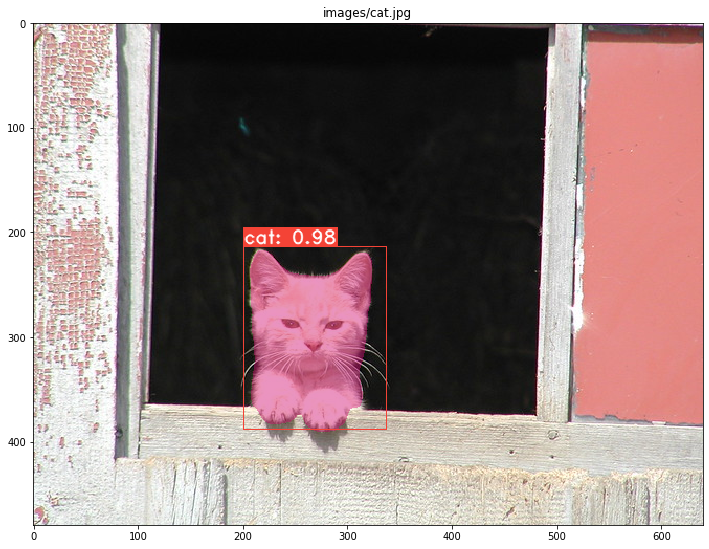

CPU times: user 5.35 s, sys: 462 ms, total: 5.81 s
Wall time: 5.88 s


In [7]:
%%time

with torch.no_grad():
    if not os.path.exists('results'):
        os.makedirs('results')

    if args.cuda:
        cudnn.fastest = True
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
    else:
        torch.set_default_tensor_type('torch.FloatTensor')

    if args.resume and not args.display:
        with open(args.ap_data_file, 'rb') as f:
            ap_data = pickle.load(f)
        calc_map(ap_data)
        exit()

    if args.image is None and args.video is None and args.images is None:
        dataset = COCODetection(cfg.dataset.valid_images, cfg.dataset.valid_info,
                                transform=BaseTransform(), has_gt=cfg.dataset.has_gt)
        prep_coco_cats()
    else:
        dataset = None
        
    if args.cuda:
        net = net.cuda()
    def parse_args(argv=None):
        global args
        args = {'trained_model': 'weights/yolact_im700_54_800000.pth', 'top_k': 3, 'cuda': True, 'fast_nms': True, 'cross_class_nms': False, 'display_masks': True, 'display_bboxes': True, 'display_text': True, 'display_scores': True, 'display': False, 'shuffle': False, 'ap_data_file': 'results/ap_data.pkl', 'resume': False, 'max_images': -1, 'output_coco_json': False, 'bbox_det_file':'results/bbox_detections.json', 'mask_det_file': 'results/mask_detections.json', 'config': 'yolact_im700_config', 'output_web_json': False, 'web_det_path': 'web/dets/', 'no_bar': False, 'display_lincomb': False, 'benchmark': False, 'no_sort': False, 'seed': None, 'mask_proto_debug': False, 'crop': True, 'image': 'images/car.jpg', 'images': None, 'video': None, 'video_multiframe': 1, 'score_threshold': 0.8, 'dataset': None, 'detect': False, 'display_fps': False, 'emulate_playback': False, 'no_hash': False}
        args['cuda'] = False
        args['top_k'] = 1
        args['score_threshold'] = 0.6
        args['image'] = 'images/cat.jpg'
        args = AttrDict(args)
    parse_args()
    plt.figure(figsize=(12, 16))
    evaluate(net, dataset)

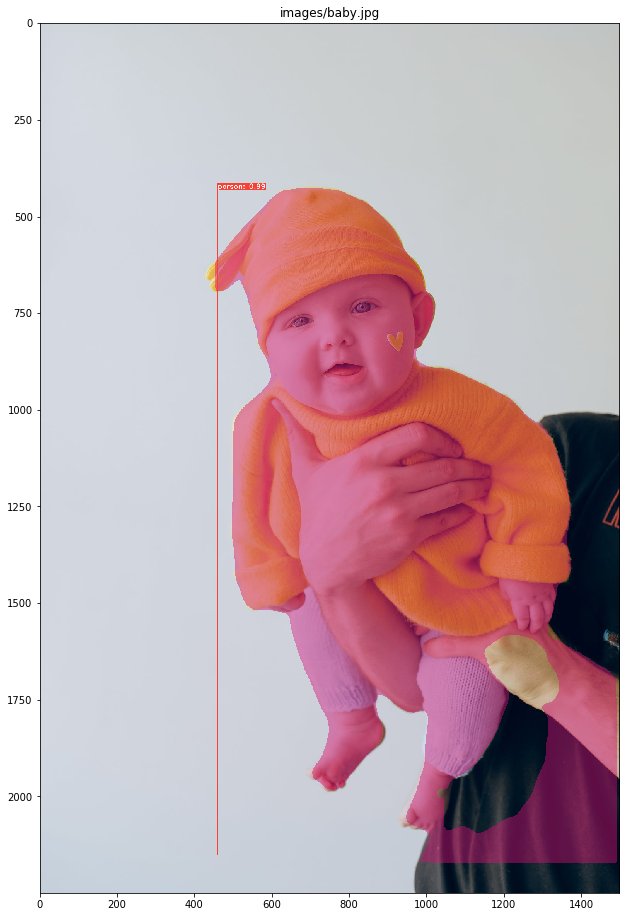

CPU times: user 5.71 s, sys: 536 ms, total: 6.25 s
Wall time: 6.35 s


In [10]:
%%time

with torch.no_grad():
    if not os.path.exists('results'):
        os.makedirs('results')

    if args.cuda:
        cudnn.fastest = True
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
    else:
        torch.set_default_tensor_type('torch.FloatTensor')

    if args.resume and not args.display:
        with open(args.ap_data_file, 'rb') as f:
            ap_data = pickle.load(f)
        calc_map(ap_data)
        exit()

    if args.image is None and args.video is None and args.images is None:
        dataset = COCODetection(cfg.dataset.valid_images, cfg.dataset.valid_info,
                                transform=BaseTransform(), has_gt=cfg.dataset.has_gt)
        prep_coco_cats()
    else:
        dataset = None
        
    if args.cuda:
        net = net.cuda()
    def parse_args(argv=None):
        global args
        args = {'trained_model': 'weights/yolact_im700_54_800000.pth', 'top_k': 3, 'cuda': True, 'fast_nms': True, 'cross_class_nms': False, 'display_masks': True, 'display_bboxes': True, 'display_text': True, 'display_scores': True, 'display': False, 'shuffle': False, 'ap_data_file': 'results/ap_data.pkl', 'resume': False, 'max_images': -1, 'output_coco_json': False, 'bbox_det_file':'results/bbox_detections.json', 'mask_det_file': 'results/mask_detections.json', 'config': 'yolact_im700_config', 'output_web_json': False, 'web_det_path': 'web/dets/', 'no_bar': False, 'display_lincomb': False, 'benchmark': False, 'no_sort': False, 'seed': None, 'mask_proto_debug': False, 'crop': True, 'image': 'images/car.jpg', 'images': None, 'video': None, 'video_multiframe': 1, 'score_threshold': 0.8, 'dataset': None, 'detect': False, 'display_fps': False, 'emulate_playback': False, 'no_hash': False}
        args['cuda'] = False
        args['top_k'] = 1
        args['score_threshold'] = 0.8
        args['image'] = 'images/baby.jpg'
        args = AttrDict(args)
    parse_args()
    plt.figure(figsize=(12, 16))
    evaluate(net, dataset)